In [1]:
#Import relevant packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
from scipy import stats
import seaborn as sns

%matplotlib inline 

pd.set_option('display.max_columns', None)

In [2]:
#Initiating SQL connection

conn = sqlite3.connect('data/im.db')
cursor = conn.cursor()

In [3]:
#Tables and schema

df = pd.read_sql("""
SELECT *
FROM sqlite_master""", conn)

df

,type,name,tbl_name,rootpage,sql


In [4]:
movie_gross_df = pd.read_csv("data/bom.movie_gross.csv.gz")

movie_gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [5]:
movie_info_df = pd.read_csv("data/rt.movie_info.tsv.gz", sep="\t", encoding='windows-1252')

movie_info_df.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [6]:
movie_reviews_df = pd.read_csv("data/rt.reviews.tsv.gz", sep="\t", encoding='windows-1252')

movie_reviews_df.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [7]:
movie_tmdb_df = pd.read_csv("data/tmdb.movies.csv.gz")

movie_tmdb_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [8]:
movie_budget_df = pd.read_csv("data/tn.movie_budgets.csv.gz")

movie_budget_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [9]:
movie_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB


In [10]:
#drop na values in box office
movie_info_df.dropna(subset=['box_office'], inplace=True)

In [11]:
movie_info_df['box_office_clean'] = movie_info_df['box_office'].str.replace(",", "").astype(int)

In [12]:
movie_info_df['genre'].value_counts()

Drama                                                         48
Comedy                                                        40
Comedy|Drama                                                  26
Drama|Mystery and Suspense                                    13
Comedy|Drama|Romance                                          11
                                                              ..
Comedy|Television                                              1
Art House and International|Horror|Mystery and Suspense        1
Action and Adventure|Animation|Science Fiction and Fantasy     1
Documentary|Musical and Performing Arts|Special Interest       1
Drama|Horror|Mystery and Suspense|Romance                      1
Name: genre, Length: 100, dtype: int64

In [13]:
comedy = 'comedy'

In [14]:
comedy_df = movie_info_df[movie_info_df['genre'].str.contains(comedy, case=False)]

In [15]:
comedy_df

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,box_office_clean
6,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,"41,032,915",82 minutes,Paramount Pictures,41032915
15,22,Two-time Academy Award Winner Kevin Spacey giv...,R,Comedy|Drama|Mystery and Suspense,George Hickenlooper,Norman Snider,"Dec 17, 2010","Apr 5, 2011",$,"1,039,869",108 minutes,ATO Pictures,1039869
19,26,A comic series of short vignettes build on one...,R,Art House and International|Comedy|Drama|Music...,Jim Jarmusch,Jim Jarmusch,"May 14, 2004","Sep 21, 2004",$,"1,971,135",96 minutes,MGM,1971135
44,57,Life doesn't always go according to plan. Pat ...,R,Comedy,NaN,NaN,"Nov 21, 2012","Apr 30, 2013",$,"132,088,910",122 minutes,The Weinstein Company,132088910
51,65,A classic Disney fairytale collides with moder...,PG,Comedy|Kids and Family|Romance,Kevin Lima,NaN,"Nov 21, 2007","Mar 18, 2008",$,"127,706,877",108 minutes,Walt Disney Pictures,127706877
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1518,1953,A glimpse into the comedic process and private...,R,Comedy|Documentary|Television,Ricki Stern|Anne Sundberg,Ricki Stern,"Jun 11, 2010","Dec 14, 2010",$,"2,927,972",84 minutes,IFC Films,2927972
1526,1962,Ridley Scott directs the crime comedy Matchsti...,PG-13,Comedy|Drama,Ridley Scott,Nicholas Griffin|Ted Griffin,"Sep 12, 2003","Jun 1, 2004",$,"36,873,198",116 minutes,Warner Bros. Pictures,36873198
1530,1968,"This holiday season, acclaimed filmmaker Camer...",PG,Comedy|Drama,Cameron Crowe,Aline Brosh McKenna|Cameron Crowe,"Dec 23, 2011","Apr 3, 2012",$,"72,700,000",126 minutes,20th Century Fox,72700000
1542,1981,"Money, Fame and the Knowledge of English. In I...",NR,Comedy|Drama,Gauri Shinde,Gauri Shinde,"Oct 5, 2012","Nov 20, 2012",$,"1,416,189",129 minutes,Eros Entertainment,1416189


In [16]:
non_comedy_df = movie_info_df[~movie_info_df['genre'].str.contains(comedy, case=False)]

In [17]:
non_comedy_df

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,box_office_clean
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,600000
7,13,"Stewart Kane, an Irishman living in the Austra...",R,Drama,Ray Lawrence,Raymond Carver|Beatrix Christian,"Apr 27, 2006","Oct 2, 2007",$,"224,114",123 minutes,Sony Pictures Classics,224114
8,14,"""Love Ranch"" is a bittersweet love story that ...",R,Drama,Taylor Hackford,Mark Jacobson,"Jun 30, 2010","Nov 9, 2010",$,"134,904",117 minutes,NaN,134904
16,23,A fictional film set in the alluring world of ...,R,Drama,NaN,NaN,"Dec 20, 2013","Mar 18, 2014",$,"99,165,609",129 minutes,Sony Pictures,99165609
18,25,"From ancient Japan's most enduring tale, the e...",PG-13,Action and Adventure|Drama|Science Fiction and...,Carl Erik Rinsch,Chris Morgan|Hossein Amini,"Dec 25, 2013","Apr 1, 2014",$,"20,518,224",127 minutes,Universal Pictures,20518224
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,1975,The year is 1953. A visiting archaeologist cal...,NR,Drama|Romance,Vikramaditya Motwane,Vikramaditya Motwane|Bhavani Iyer|Anurag Kashyap,"Jul 3, 2013","Jan 12, 2015",$,"581,813",142 minutes,NaN,581813
1537,1976,"Embrace of the Serpent features the encounter,...",NR,Action and Adventure|Art House and International,Ciro Guerra,Ciro Guerra|Jacques Toulemonde Vidal,"Feb 17, 2016","Jun 21, 2016",$,"1,320,005",123 minutes,Buffalo Films,1320005
1541,1980,A band of renegades on the run in outer space ...,PG-13,Action and Adventure|Science Fiction and Fantasy,Joss Whedon,Joss Whedon,"Sep 30, 2005","Dec 20, 2005",$,"25,335,935",119 minutes,Universal Pictures,25335935
1545,1985,A woman who joins the undead against her will ...,R,Horror|Mystery and Suspense,Sebastian Gutierrez,Sebastian Gutierrez,"Jun 1, 2007","Oct 9, 2007",$,"59,371",98 minutes,IDP Distribution,59371


In [18]:
comedy = comedy_df['box_office_clean'].values
non_comedy = non_comedy_df['box_office_clean'].values

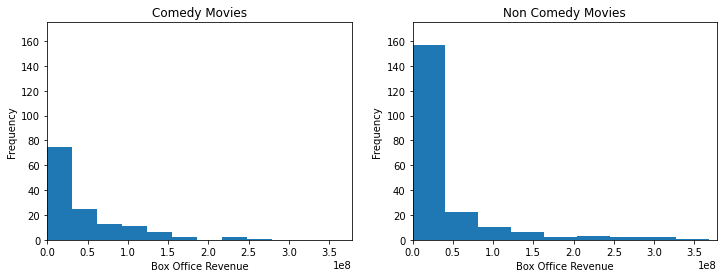

In [19]:
#Visuals 
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

bin_size = 9

ax1.set_title('Comedy Movies')
ax1.set_xlabel('Box Office Revenue')
ax1.set_ylabel('Frequency')
ax1.hist(comedy, bins = bin_size)

ax2.set_title('Non Comedy Movies')
ax2.set_xlabel('Box Office Revenue')
ax2.set_ylabel('Frequency')
ax2.hist(non_comedy, bins = bin_size)

max_x = max(max(comedy), max(non_comedy)) + 10000000
max_y = 175

ax1.set_xlim(0, max_x)
ax1.set_ylim(0, max_y)
ax2.set_xlim(0, max_x)
ax2.set_ylim(0, max_y)

plt.show();

In [20]:
#Two sample t-test
pvalue = stats.ttest_ind(comedy, non_comedy, equal_var = False).pvalue / 2
pvalue

0.1422881898909963

In [21]:
drama = 'drama'

In [22]:
drama_df = movie_info_df[movie_info_df['genre'].str.contains(drama, case=False)]

In [23]:
drama_df

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,box_office_clean
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,600000
7,13,"Stewart Kane, an Irishman living in the Austra...",R,Drama,Ray Lawrence,Raymond Carver|Beatrix Christian,"Apr 27, 2006","Oct 2, 2007",$,"224,114",123 minutes,Sony Pictures Classics,224114
8,14,"""Love Ranch"" is a bittersweet love story that ...",R,Drama,Taylor Hackford,Mark Jacobson,"Jun 30, 2010","Nov 9, 2010",$,"134,904",117 minutes,NaN,134904
15,22,Two-time Academy Award Winner Kevin Spacey giv...,R,Comedy|Drama|Mystery and Suspense,George Hickenlooper,Norman Snider,"Dec 17, 2010","Apr 5, 2011",$,"1,039,869",108 minutes,ATO Pictures,1039869
16,23,A fictional film set in the alluring world of ...,R,Drama,NaN,NaN,"Dec 20, 2013","Mar 18, 2014",$,"99,165,609",129 minutes,Sony Pictures,99165609
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526,1962,Ridley Scott directs the crime comedy Matchsti...,PG-13,Comedy|Drama,Ridley Scott,Nicholas Griffin|Ted Griffin,"Sep 12, 2003","Jun 1, 2004",$,"36,873,198",116 minutes,Warner Bros. Pictures,36873198
1530,1968,"This holiday season, acclaimed filmmaker Camer...",PG,Comedy|Drama,Cameron Crowe,Aline Brosh McKenna|Cameron Crowe,"Dec 23, 2011","Apr 3, 2012",$,"72,700,000",126 minutes,20th Century Fox,72700000
1536,1975,The year is 1953. A visiting archaeologist cal...,NR,Drama|Romance,Vikramaditya Motwane,Vikramaditya Motwane|Bhavani Iyer|Anurag Kashyap,"Jul 3, 2013","Jan 12, 2015",$,"581,813",142 minutes,NaN,581813
1542,1981,"Money, Fame and the Knowledge of English. In I...",NR,Comedy|Drama,Gauri Shinde,Gauri Shinde,"Oct 5, 2012","Nov 20, 2012",$,"1,416,189",129 minutes,Eros Entertainment,1416189


In [24]:
non_drama_df = movie_info_df[~movie_info_df['genre'].str.contains(drama, case=False)]

In [25]:
non_drama_df

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,box_office_clean
6,10,Some cast and crew from NBC's highly acclaimed...,PG-13,Comedy,Jake Kasdan,Mike White,"Jan 11, 2002","Jun 18, 2002",$,"41,032,915",82 minutes,Paramount Pictures,41032915
44,57,Life doesn't always go according to plan. Pat ...,R,Comedy,NaN,NaN,"Nov 21, 2012","Apr 30, 2013",$,"132,088,910",122 minutes,The Weinstein Company,132088910
51,65,A classic Disney fairytale collides with moder...,PG,Comedy|Kids and Family|Romance,Kevin Lima,NaN,"Nov 21, 2007","Mar 18, 2008",$,"127,706,877",108 minutes,Walt Disney Pictures,127706877
52,66,"Niels Arden Oplev, the acclaimed director of t...",R,Mystery and Suspense,Niels Arden Oplev,NaN,"Mar 8, 2013","Jul 9, 2013",$,"10,880,926",118 minutes,FilmDistrict,10880926
60,75,Nicolas Cage headlines this high-octane thrill...,R,Action and Adventure|Mystery and Suspense,Patrick Lussier,NaN,"Feb 25, 2011","May 31, 2011",$,"10,706,786",107 minutes,Summit Entertainment,10706786
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1528,1965,"Because of a misunderstanding on his part, Cli...",G,Animation|Kids and Family,Robert Ramirez,Robert Ramirez|Rhett Reese,"Apr 23, 2004","Aug 24, 2004",$,"2,782,548",73 minutes,Warner Bros. Pictures,2782548
1537,1976,"Embrace of the Serpent features the encounter,...",NR,Action and Adventure|Art House and International,Ciro Guerra,Ciro Guerra|Jacques Toulemonde Vidal,"Feb 17, 2016","Jun 21, 2016",$,"1,320,005",123 minutes,Buffalo Films,1320005
1541,1980,A band of renegades on the run in outer space ...,PG-13,Action and Adventure|Science Fiction and Fantasy,Joss Whedon,Joss Whedon,"Sep 30, 2005","Dec 20, 2005",$,"25,335,935",119 minutes,Universal Pictures,25335935
1545,1985,A woman who joins the undead against her will ...,R,Horror|Mystery and Suspense,Sebastian Gutierrez,Sebastian Gutierrez,"Jun 1, 2007","Oct 9, 2007",$,"59,371",98 minutes,IDP Distribution,59371


In [26]:
drama = drama_df['box_office_clean'].values
non_drama = non_drama_df['box_office_clean'].values

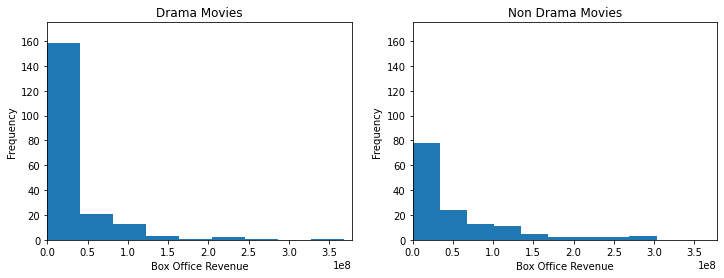

In [27]:
#Visuals for Drama
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

bin_size = 9

ax1.set_title('Drama Movies')
ax1.set_xlabel('Box Office Revenue')
ax1.set_ylabel('Frequency')
ax1.hist(drama, bins = bin_size)

ax2.set_title('Non Drama Movies')
ax2.set_xlabel('Box Office Revenue')
ax2.set_ylabel('Frequency')
ax2.hist(non_drama, bins = bin_size)

max_x = max(max(drama), max(non_drama)) + 10000000
max_y = 175

ax1.set_xlim(0, max_x)
ax1.set_ylim(0, max_y)
ax2.set_xlim(0, max_x)
ax2.set_ylim(0, max_y)

plt.show();